<div style="background-color:#f0f8ff; border-radius:8px; padding:12px; text-align:center;">

# **PRACTICA 2: Árboles y Ensembles**

</div>

*Aprendizaje Automático*

---

**Grupo:** G-7312  
**Número de pareja:** 01  
**Miembros:**  
- Leire Bernárdez Vázquez  
- Carmen Reiné Rueda

---

### **Importaciones**

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_covtype
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_circles
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor



### **1. Clasificación mediante  ́arboles de clasificación**

---
**1. Cargue los datos del problema**

In [2]:
# Load the Covertype dataset
cov_type = fetch_covtype()
# Separate the features and the target variable
X = cov_type.data
y = cov_type.target

**2. Separe los datos en training (50 %) y test (50 %)**

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

No hace falta escalarlo, (los árboles se tragan todo lo que les des)

**3. Utilice la clase DecisionTreeClassifier de Sklearn para resolver el problema
y dé un resultado de test usando la m ́etrica que considere oportuna**

In [4]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
porcentaje = accuracy_score(y_test, y_pred)
print("Accuracy:", porcentaje*100, "%")

Accuracy: 92.35747282328076 %


**4. ¿Había missing values en nuestro problema? ¿Qué efecto tendría en los árboles no completar los missing values ?**

In [5]:
np.isnan(X_train).sum()==0

True

Si existieran y no se imputaran, DecisionTreeClassifier daría error al entrenar, porque los árboles no soportan missing values; requieren que todos los datos estén completos para funcionar. Para solucionar este problema, se podrían imputar con media, mediana o un valor concreto.

**5. ¿Con qué parémetro podría controlarse la profundidad del ́arbol? ¿Qué ocurre si un ́arbol se inicializa sin dar un valor concreto a ese parámetro? ¿Crees que sería una buena práctica no darle ningún valor?**

a) La profundidad máxima del árbol se controla con el parámetro max_depth directamente, que por defecto es max_depth=None. Sin embargo, también se puede controlar indirectamente con min_samples_split, que no divide un nodo si tiene menos muestras que las requeridas, y con min_samples_leaf, que obliga a que cada hoja tenga un mínimo de muestras para evitar que existan ramas muy profundas con pocas muestras. Por lo tanto, con estos valores se reduce la profundidad máxima alcanzada.

b) Crecería tanto como datos se le pasaran sin ningún tipo de límite.

c) No, debido a que sin un límite establecido, los árboles grandes consumen más memoria, tardan más en entrenar y tienden a sobreajustarse más fácilmente. Con lo cual, sería importante definir un max_depth razonable teniendo en cuenta los datos.

**6. ¿Son sensibles los ́arboles al desequilibrio entre clases?**

Sí, los árboles de decisión se ven afectados cuando las clases están desbalanceadas. Tratan de que cada hoja tenga solo un tipo de clase, así que cuando una clase es mayoritaria, las divisiones tienden a favorecerla. Esto puede hacer que las clases minoritarias queden mezcladas o se clasifiquen mal.

Si no se corrige este desequilibrio, el árbol aprenderá principalmente la clase mayoritaria y puede fallar al predecir las clases minoritarias, aunque acierte mucho con la clase que domina.


**7. ¿Existe desequilibrio entre las clases de nuestro problema? ¿Con qué parámetro de la clase DecisionTreeClassifier podrías corregirlo?**

In [6]:
counts = np.bincount(y)  # y debe ser enteros >=0
print({i: count for i, count in enumerate(counts) if count > 0})

{1: 211840, 2: 283301, 3: 35754, 4: 2747, 5: 9493, 6: 17367, 7: 20510}


a) Para comprobar si existe desequilibrio entre las clases del dataset Covtype, hemos utilizado la función np.bincount sobre las etiquetas de cada muestra.  

   Esta función nos permite contar cuántas muestras hay de cada clase y así analizar la distribución de los datos. Los resultados muestran que algunas clases tienen muchas más muestras que otras, confirmando que sí existe desequilibrio entre las clases.  

b) Podríamos corregirlo utilizando el parámetro class_weight='balanced  en DecisionTreeClassifier, que ajusta automáticamente los pesos de cada clase en función de su frecuencia en el dataset.

**8. ¿Cuál es la diferencia entre los parámetros min samples split y min samples leaf ?**

 **`min_samples_split`** 

**Definición según la documentación:** El número mínimo de muestras necesarias para dividir un nodo interno.

Este parámetro decide si un nodo se puede dividir. 
- Si el grupo de datos tiene suficientes muestras según el valor indicado, el nodo se divide en dos o más partes.  
- Si no tiene suficientes, el nodo se queda igual y se convierte en hoja.


**`min_samples_leaf`**  

**Definición según la documentación:** El número mínimo de muestras necesarias para estar en un nodo hoja. Un punto de división a cualquier profundidad solo se considerará si sale a menos muestras de entrenamiento en cada una de las muestras de entrenamiento izquierdo y ramas derechas. Esto puede tener el efecto de suavizar el modelo

Este parámetro se utiliza después de dividir un nodo para comprobar si cada hoja tiene suficientes muestras.  
- Si alguna hoja tiene menos muestras que el valor indicado, la división no se realiza.


**9. ¿Para qué sirve el parémetro criterion, qué valores puede tomar y qué significa o representa cada uno de esos valores?**

El parámetro criterion sirve para decidir qué tan buena es una división en un árbol de decisión. Es decir, indica cómo medir la calidad de los splits.

Los valores que puede tomar son:

- **gini** → utiliza el índice de Gini, que mide la impureza de un nodo.  
  Busca que cada hoja tenga muestras de la misma clase lo más posible.  

- **entropy** → utiliza la ganancia de información de Shannon.  
  Calcula cuánto disminuye la incertidumbre o desorden al hacer un split.  
  
- **log_loss** → también mide la ganancia de información, pero usando pérdida logarítmica.

**10. El ́arbol entrenado, ¿realiza splits utilizando todas las variables disponibles?**

In [7]:
importances = decision_tree.feature_importances_
used_features = [(i, imp) for i, imp in enumerate(importances) if imp > 0]
print("Variables usadas con importancia:", used_features)


Variables usadas con importancia: [(0, 0.3395257450926996), (1, 0.027434974583562706), (2, 0.017030682281356086), (3, 0.060476014932761474), (4, 0.04728598019235194), (5, 0.14703630083405603), (6, 0.03166307086673707), (7, 0.033797981854944474), (8, 0.024115949546914057), (9, 0.14500689436345346), (10, 0.00876175562062018), (11, 0.0028052316000965324), (12, 0.013193144827120345), (13, 0.001047149020047524), (14, 0.0002608345451055798), (15, 0.009749899148641984), (16, 0.001371998748136303), (17, 0.011246491731115301), (18, 0.0002653376729426191), (19, 0.0006295307820896887), (21, 1.8682256027925262e-05), (22, 0.00011716541185293033), (23, 0.0026638269982027975), (24, 0.0018717302916287132), (25, 0.0009763802938077641), (26, 0.003351679813362635), (27, 9.220816306941631e-05), (28, 1.0886440090901791e-05), (29, 0.0007652338826561621), (30, 0.001182617096159395), (31, 1.6251804811961362e-05), (32, 0.0009903055097179707), (33, 0.0029801258698040284), (34, 0.00030524645632850147), (35, 0.00

Cada tupla (índice, importancia) indica qué columna se utilizó en algún split del árbol y cuánto aportó a la decisión de dividir los nodos.

Observando las importancias de las variables de nuestro árbol:

- No todas las variables se utilizan en los splits.  
- Solo se usan aquellas que aportan información útil para separar las clases, mientras que las demás quedan con importancia 0 y no aparecen en ningún nodo.  
- Aunque el árbol analiza todas las variables disponibles, solo mantiene en el modelo final las que realmente ayudan a mejorar la clasificación.



**11. ¿Se le ocurre alguna forma de crear un selector de atributos a partir de un árbol de clasificación?**

Aprovechando la importancia de cada variable feature_importances, podemos utilizar el árbol de decisión como selector de atributos.

- Manteniendo únicamente las variables que realmente aportan información al modelo.  
- Las variables con importancia 0 o muy baja pueden eliminarse, ya que no influyen en los splits.  
- Esto permite reducir la dimensionalidad, simplificar el modelo e incluso en algunos casos mejorar la generalización.

En Scikit-Learn se puede hacer fácilmente con SelectFromModel usando el árbol entrenado `decision_tree´.


In [8]:
selector = SelectFromModel(decision_tree, threshold=0.01, prefit=True)
X_selected = selector.transform(X)

print(f"Número de variables originales: {X.shape[1]}")
print(f"Número de variables seleccionadas: {X_selected.shape[1]}")


Número de variables originales: 54
Número de variables seleccionadas: 13


SelectFromModel mira decision_tree.feature_importances_ y compara cada valor con  threshold = 0,01.  
Si la importancia es mayor o igual al threshold, se mantiene; si es menor, se descarta.  
Al hacer X_selected = selector.transform(X) conservamos solo las columnas importantes.



### **2. Regresión mediante árboles de regresión**

#### **2.1. Obtención de los datos**

**Descargue los datos de Sklearn**

In [9]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
X, y = data.data, data.target

**Separe los datos en training (50 %) test (50 %) y realice el preprocesado de los
datos que estime conveniente teniendo en cuenta que el modelo de aprendizaje con
el que va a tratar de resolver el problema es un  ́arbol de regresión. Finalmente
responda a las siguientes preguntas**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

En el caso del árbol de regresión, no es necesario aplicar técnicas de escalado ni normalización, ya que no son sensibles a la escala de los atributos al realizar sus particiones.

Como preprocesado vamos a comprobar que el conjunto de datos no contenga valores faltantes, revisaremos las principales estadísticas de los atributos para asegurarnos de que todo está en orden antes del entrenamiento.

In [11]:
df = pd.DataFrame(X, columns=data.feature_names)
print(df.isnull().sum())      

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64


In [12]:
print(f"Shape X: {X.shape}")
print(f"Shape y: {y.shape}")
print(df.describe())

Shape X: (20640, 8)
Shape y: (20640,)
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude  
count  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704  
std       10.386050      2.135952      2.003532  
min        0.692308     32.540000   -124.350000  


**1. ¿Podría trabajar un arbol de regresión con missing values?**

Sí.

El modelo DecisionTreeRegressor tienen soporte integrado para valores faltantes.
Durante el entrenamiento, el árbol evalúa las divisiones usando los datos disponibles y distribuye los valores faltantes según las reglas aprendidas.

Al predecir, las muestras con valores faltantes se asignan automáticamente al nodo más probable según el comportamiento observado durante el entrenamiento.

Referencia oficial: [https://scikit-learn.org/stable/modules/tree.html#missing-values-support](https://scikit-learn.org/stable/modules/tree.html#missing-values-support)




**2. ¿Es sensible un ́arbol de regresión a las magnitudes de los atributos?**

No.
Los árboles de regresión no son sensibles a la escala ni a las magnitudes de los atributos, ya que las divisiones se basan únicamente en comparaciones (x_j < t) y no en distancias ni relaciones de proporción entre variables.

Por eso no es necesario escalar ni normalizar los datos antes de entrenar el modelo.
Esta es una de las ventajas que destaca la documentación oficial: los árboles de decisión requieren muy poca preparación de datos en comparación con otros modelos como KNN, que sí dependen de la escala.

Referencia oficial: [https://scikit-learn.org/stable/modules/tree.html#](https://scikit-learn.org/stable/modules/tree.html#)


**3. ¿Es sensible un árbol de regresión a la distribución de las etiquetas?**

Sí, en cierta medida.
Los árboles de regresión minimizan el error cuadrático medio (MSE) al crear las divisiones, por lo que los valores de salida muy altos o atípicos (outliers) pueden influir más en el ajuste del modelo.
Esto significa que si las etiquetas (y) están muy desbalanceadas o contienen valores extremos, el árbol puede sobreajustarse a esos casos.

Para evitarlo, la documentación recomienda controlar la complejidad del árbol con parámetros como:

* max_depth → limita la profundidad máxima.
* min_samples_split → exige un mínimo de muestras para dividir un nodo.
* min_samples_leaf → asegura que cada hoja tenga suficientes muestras.

También se puede aplicar una transformación de las etiquetas (por ejemplo, np.log1p(y)) para reducir el impacto de los valores muy grandes.

Referencia oficial: [https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use](https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use)



#### **2.2 Implementación de un árbol de regresión**



In [13]:
from regression_tree import RegressionTree

#### **2.3. Nos enfrentamos al problema de California Housing**

**1. ¿Cómo evoluciona el error de training y test conforme se aumenta la profundidad del  ́arbol? Base su razonamiento en dos gráficas obtenidas con matplotlib.**

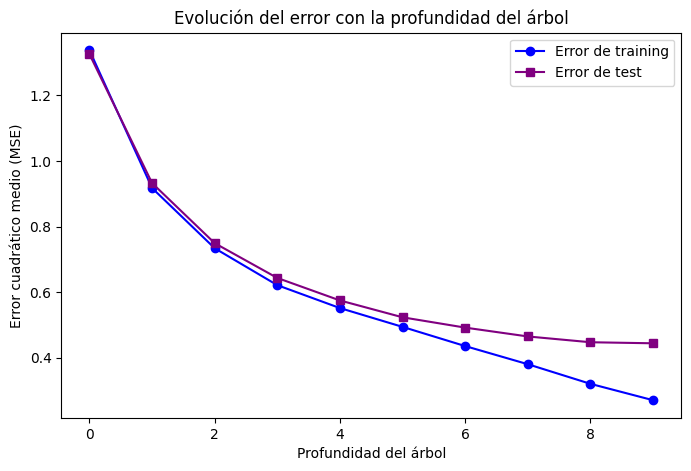

Mejor profundidad: 9
Mejor error en test (MSE): 0.4443


In [14]:
depths = range(0, 10)
train_errors = []
test_errors = []

for d in depths:
    tree = RegressionTree(max_depth=d, min_samples_split=5)
    tree.fit(X_train, y_train)

    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    train_errors.append(train_mse)
    test_errors.append(test_mse)

# --- Representar resultados ---
plt.figure(figsize=(8,5))
plt.plot(depths, train_errors, 'o-', label="Error de training", color='blue')
plt.plot(depths, test_errors, 's-', label="Error de test", color='purple')
plt.xlabel("Profundidad del árbol")
plt.ylabel("Error cuadrático medio (MSE)")
plt.title("Evolución del error con la profundidad del árbol")
plt.legend()
plt.show()

# --- Mostrar mejor resultado ---
best_depth = depths[np.argmin(test_errors)]
best_test_error = min(test_errors)

print(f"Mejor profundidad: {best_depth}")
print(f"Mejor error en test (MSE): {best_test_error:.4f}")

En la gráfica se observa que, al aumentar la profundidad del árbol, el error de entrenamiento disminuye de forma continua, ya que el modelo puede ajustarse mejor a los datos.
El error de test también baja al principio, lo que indica que el modelo generaliza mejor, pero a partir de cierta profundidad las mejoras son pequeñas.

En nuestro caso, el menor error de test (MSE = 0.4443) se obtiene con una profundidad = 9, que es el punto donde el modelo logra su mejor equilibrio entre ajuste y generalización.
A profundidades más bajas el modelo no aprende lo suficiente, y a mayores profundidades podría empezar a sobreajustar.

**2. ¿Sobre qué parámetros tendría sentido realizar cross-validation en nuestro modelo?**


En nuestro modelo tendría sentido aplicar cross-validation para ajustar los parámetros que controlan la complejidad del árbol, especialmente max_depth y min_samples_split.

Estos parámetros influyen directamente en el equilibrio entre subajuste y sobreajuste.
Mediante validación cruzada podemos probar varios valores y elegir aquellos que den el menor error medio en las particiones de validación.

**3. Tome un par de muestras y utilizando el método decision_path(x) justifique la predicción dada. Como habrá comprobado, el método decision_path(x) devuelve una lista ordenada de argumentos, suponga que esa lista se desordena: ¿seguiría siendo válida la interpretación de la predicción?**

In [15]:
# Entrenamos el árbol óptimo encontrado en el apartado 1
tree = RegressionTree(max_depth=best_depth, min_samples_split=5)
tree.fit(X_train, y_train)

# Seleccionamos dos muestras del conjunto de test
x1 = X_test[0]
x2 = X_test[1]

print("Valor real 1:", y_test[0])
print("Predicción 1:", tree.predict([x1])[0])
print("\nCamino de decisión 1:\n", tree.decision_path(x1))

print("\n--------------------------------------\n")

print("Valor real 2:", y_test[1])
print("Predicción 2:", tree.predict([x2])[0])
print("\nCamino de decisión 2:\n", tree.decision_path(x2))

Valor real 1: 0.477
Predicción 1: 0.5476714925373135

Camino de decisión 1:
 1. Atributo 0 menor que 5.33755
2. Atributo 0 menor que 3.0764
3. Atributo 2 menor que 4.33520393767439
4. Atributo 5 mayor que 2.510661936212527
5. Atributo 0 menor que 2.2213000000000003
6. Atributo 2 mayor que 3.5012269588540774
7. Atributo 6 mayor que 35.32
8. Atributo 7 mayor que -121.565
9. Atributo 7 mayor que -120.67
Predicción final = 0.548

--------------------------------------

Valor real 2: 0.458
Predicción 2: 0.7968000000000001

Camino de decisión 2:
 1. Atributo 0 menor que 5.33755
2. Atributo 0 menor que 3.0764
3. Atributo 2 mayor que 4.33520393767439
4. Atributo 0 mayor que 2.4193499999999997
5. Atributo 5 mayor que 2.17817640685026
6. Atributo 6 mayor que 34.49
7. Atributo 7 mayor que -121.82499999999999
8. Atributo 7 mayor que -119.91
9. Atributo 2 menor que 6.102009456264775
Predicción final = 0.797


En cada muestra se muestra la secuencia de decisiones que sigue el árbol desde la raíz hasta la hoja donde obtiene la predicción.
Cada comparación indica si la muestra va hacia el hijo izquierdo o derecho según el valor de un atributo.

Si el orden de las decisiones se cambiara, la interpretación no sería válida, ya que el recorrido del árbol depende de ese orden para determinar el valor final predicho.

**4. Para una muestra idéntica a la del apartado anterior, si se entrenara un nuevo árbol, ¿la justificación de su predicción sería la misma?**

Si el árbol se entrena con los mismos datos e hiperparámetros, y la implementación es determinista, la justificación de la predicción será la misma.

En este caso, no existirán diferencias en las divisiones ni en el camino de decisión, por lo que tanto la predicción final como la explicación asociada serán idénticas.

**5. Suponga que divide el conjunto de train en dos mitades, entrena dos árboles distintos, uno con cada mitad, y toma una muestra de test. ¿Sería la predicción de la muestra igual en cada árbol? ¿Y la interpretación obtenida con decision_path(x)? ¿Qué repercusión en la interpretación tendría esa situación?**


Si dividimos el conjunto de entrenamiento en dos partes y entrenamos dos árboles diferentes, cada uno aprenderá con datos distintos.

- **Predicción:**

   Lo más probable es que la predicción de una misma muestra no sea exactamente igual en ambos árboles.
Cada modelo habrá aprendido reglas y umbrales diferentes según los datos que vio.

- **Camino de decisión (decision_path(x)):**

   También será distinto en cada árbol, ya que las condiciones (atributos y valores límite) que usa el árbol para decidir pueden cambiar.

- **Repercusión en la interpretación:**

     Esto significa que la explicación de la predicción no es única: depende del conjunto de datos con el que se entrene el modelo.
  
  Por tanto, si los datos cambian, las decisiones y las justificaciones también pueden cambiar, incluso aunque el resultado final sea parecido.

**6. Utilice la clase DecisionTreeRegressor de Sklearn para resolver de nuevo el problema. Compare el score de ambos modelos y, para alguna muestra, el resultado de decision_path(x) de ambos árboles.**

In [16]:
from sklearn.tree import DecisionTreeRegressor

# Entrenar árbol de sklearn con misma profundidad óptima
sk_tree = DecisionTreeRegressor(max_depth=best_depth, random_state=0)
sk_tree.fit(X_train, y_train)

# Calcular score y compararlo con el modelo propio
from sklearn.metrics import mean_squared_error

score_sklearn = sk_tree.score(X_test, y_test)
score_propio = 1 - mean_squared_error(y_test, tree.predict(X_test)) / np.var(y_test)

print("Score sklearn:", score_sklearn)
print("Score modelo propio:", score_propio)

# Comparar predicciones para una muestra
x = X_test[0]
print("\nValor real:", y_test[0])
print("Predicción modelo propio:", tree.predict([x])[0])
print("Predicción sklearn:", sk_tree.predict([x])[0])

# Mostrar camino de decisión del modelo sklearn
node_indicator = sk_tree.decision_path([x])
feature = sk_tree.tree_.feature
threshold = sk_tree.tree_.threshold

print("\nCamino de decisión sklearn:")
for node_id in node_indicator.indices:
    if threshold[node_id] != -2:  # -2 indica hoja
        signo = "≤" if x[feature[node_id]] <= threshold[node_id] else ">"
        print(f"Atributo {feature[node_id]} {signo} {threshold[node_id]:.3f}")


Score sklearn: 0.6649906470174527
Score modelo propio: 0.6647817762496147

Valor real: 0.477
Predicción modelo propio: 0.5476714925373135
Predicción sklearn: 0.5476714925373133

Camino de decisión sklearn:
Atributo 0 ≤ 5.338
Atributo 0 ≤ 3.076
Atributo 2 ≤ 4.335
Atributo 5 > 2.511
Atributo 0 ≤ 2.221
Atributo 2 > 3.501
Atributo 6 > 35.320
Atributo 7 > -121.565
Atributo 7 > -120.670


Al comparar el modelo implementado manualmente con la clase DecisionTreeRegressor de scikit-learn, se observa que ambos alcanzan prácticamente el mismo rendimiento:

- **Score sklearn = 0.66499**

- **Score modelo propio = 0.66478**

Para una muestra de test, las predicciones también coinciden (≈ 0.5477), y el camino de decisión (decision_path(x)) es casi idéntico en ambos casos.

Esto demuestra que la implementación manual reproduce correctamente el comportamiento del árbol de regresión de scikit-learn, aunque este último está optimizado internamente para mayor precisión y velocidad.

**7. En base a su implementación ¿cuál es el coste computacional teórico de entrenar un árbol? ¿Y cuál sería el coste en predicción? ¿Y el coste en memoria? Si tuviera que resolver un problema con un conjunto de datos de gran volumen, ¿qué preferiría usar, un árbol o un modelo de regresión lineal?**

**1. Coste de entrenamiento**

El entrenamiento se realiza mediante llamadas recursivas a los métodos _best_split() y _construir_nivel().
En _best_split(X, y) tenemos el siguiente coste en cada línea:

* np.unique(X[:, f]) y np.sort(...): ordenación de n valores → **O(n log n)**.
* Bucle sobre umbrales for t in thresholds: con comparación y cálculo de error → **O(n)** por umbral.
* Como el número de umbrales es proporcional a n, el coste por atributo es **O(n²)**.
* Con d atributos: **O(d · n²)** por nodo.

El método _construir_nivel() llama recursivamente a _best_split() en cada nivel del árbol hasta agotar la profundidad máxima (max_depth). En un árbol equilibrado la profundidad media es proporcional a log n, por lo que el coste total del entrenamiento es:

$$
O(d \, n^2 \log n)
$$

**2. Coste de predicción**

El método _predict_sample() realiza una única comparación por nivel:

```python
if x[nodo.f_index] <= nodo.threshold:
    return self._predict_sample(x, nodo.left)
else:
    return self._predict_sample(x, nodo.right)
```

Para una muestra, el número de operaciones es igual a la profundidad del árbol (h).
Por tanto:

* Coste por muestra: **O(h)**.
* Coste total para n muestras: **O(n · h)**.

La predicción es eficiente, dado que h suele ser pequeño respecto a n.

**3. Coste en memoria**

Cada nodo almacena un índice de atributo, un umbral, un valor medio y referencias a los hijos izquierdo y derecho:

```python
self.f_index, self.threshold, self.value, self.left, self.right
```

Cada nodo ocupa espacio constante (**O(1)**).
El número total de nodos crece de forma proporcional al número de divisiones efectuadas, por lo que el coste en memoria es:

$$
O(n)
$$



**4. Comparación con un modelo de regresión lineal**

En la implementación desarrollada, el coste de entrenamiento es elevado debido a la evaluación exhaustiva de todos los posibles puntos de corte, lo que produce una complejidad aproximada de $O(d \, n^2 \log n)$. La predicción es rápida,  ($O(h)$), y el coste en memoria crece linealmente con el número de nodos. Ante conjuntos de datos de gran tamaño, resulta preferible una regresión lineal, que presenta un entrenamiento y almacenamiento significativamente más eficientes.





### **3. Ensembles**

#### **3.1. Ensembles basados en árboles**

En esta sección tratará de resolver el problema de la sección segunda utilizando los siguientes métodos de *ensemble* que encontrará en la biblioteca de **Sklearn**:

* **Bagging.**
* **Random forest.**
* **Gradient boosting.**

Deberá resolver el problema con el máximo de *accuracy* en *test*, siguiendo prácticas adecuadas de aprendizaje automático. Tras ello, responda razonadamente a las siguientes preguntas:


In [17]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Definimos los pipelines
pipelines = {
    "Bagging": Pipeline([
        ("model", BaggingRegressor(
            estimator=DecisionTreeRegressor(
                max_depth=None,
                min_samples_split=5,
                min_samples_leaf=3,
                random_state=42
            ),
            n_estimators=150,
            max_samples=1.0,
            max_features=1.0,
            random_state=42,
            n_jobs=-1
        ))
    ]),

    "RandomForest": Pipeline([
        ("model", RandomForestRegressor(
            n_estimators=200,
            max_depth=None,
            min_samples_split=5,
            min_samples_leaf=3,
            random_state=42,
            n_jobs=-1
        ))
    ]),

    "GradientBoosting": Pipeline([
        ("model", GradientBoostingRegressor(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=3,
            min_samples_split=5,
            min_samples_leaf=3,
            subsample=1.0,
            random_state=42
        ))
    ])
}

# Entrenamiento y evaluación
results = []
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results.append({
        "Modelo": name,
        "R2_test": r2,
        "MSE_test": mse
    })

# DataFrame con los resultados
df_results = pd.DataFrame(results).sort_values(by="R2_test", ascending=False).reset_index(drop=True)
df_results

,Modelo,R2_test,MSE_test
0,GradientBoosting,0.803744,0.260132
1,RandomForest,0.792307,0.275290
2,Bagging,0.792306,0.275292



**1. ¿Cuáles son los hiperparámetros más relevantes de los métodos anteriores?**


**BaggingRegressor**

Los hiperparámetros más relevantes son:

* **n_estimators**: número de estimadores o modelos base que conforman el ensemble.
* **max_samples**: proporción de muestras del conjunto de entrenamiento empleadas en cada estimador.
* **max_features**: proporción de características seleccionadas para cada modelo base.

Estos parámetros controlan la diversidad entre los modelos y, por tanto, la reducción de varianza obtenida mediante el bagging.

**RandomForestRegressor**

Los hiperparámetros más determinantes son:

* **n_estimators**: número total de árboles que forman el bosque.
* **max_depth**: profundidad máxima de los árboles individuales.
* **max_features**: número máximo de variables consideradas en cada división.

Estos parámetros influyen directamente en la complejidad del modelo y en el equilibrio entre precisión y capacidad de generalización**.

**GradientBoostingRegressor**

Los hiperparámetros más relevantes son:

* **n_estimators**: número de árboles añadidos de forma secuencial.
* **learning_rate**: tasa de aprendizaje que regula la contribución de cada nuevo árbol.

Estos parámetros determinan el compromiso entre sesgo y varianza y el ritmo de aprendizaje del modelo.

**2. ¿Es cierto que el uso de *ensembles* mejora el *accuracy* de un estimador aislado?**


Los ensembles no reducen el sesgo de los modelos base, sino su varianza.

Por ejemplo, Bagging y Boosting combinan muchos modelos entrenados con diferentes subconjuntos de datos para que, al promediar sus resultados, el modelo final sea más estable y menos sensible al azar del entrenamiento.

Si el modelo base tiene un sesgo alto (por ejemplo, una Regresión Logística en un problema no lineal), el ensemble no lo va a corregir, porque todos los modelos cometerán el mismo tipo de error.

En cambio, si el modelo base tiene alta varianza (por ejemplo, un árbol de decisión que cambia mucho según los datos), el ensemble sí mejora el rendimiento al suavizar esas diferencias.

En resumen: **los ensembles reducen la varianza, no el sesgo**, y por eso mejoran el rendimiento solo cuando los modelos base son inestables o variables.

**3. ¿Cuantos más estimadores siempre es mejor?**


No siempre. En general, usar más estimadores puede mejorar el modelo al hacerlo más estable y reducir los errores, pero llega un punto en el que añadir más no mejora el resultado y solo aumenta el tiempo de entrenamiento.

En Bagging y Random Forest, más árboles ayudan al principio, pero después el rendimiento se estabiliza.
En Gradient Boosting, usar demasiados estimadores puede incluso empeorar el modelo si la tasa de aprendizaje es alta, ya que puede sobreajustarse a los datos de entrenamiento.

En conclusión, no por tener más estimadores el modelo será mejor: lo importante es encontrar un número adecuado que equilibre precisión y eficiencia.

**4. ¿Se mantiene la interpretabilidad de los modelos anteriores?**


No, la interpretabilidad disminuye notablemente en los modelos ensemble.
Mientras que un árbol de decisión individual es fácil de entender, ya que permite seguir las reglas de decisión que llevan a una predicción, es decir, las condiciones que el modelo utiliza para dividir los datos y determinar el resultado, métodos como Bagging, Random Forest o Gradient Boosting combinan muchos árboles, haciendo que el proceso interno sea mucho más complejo y difícil de explicar.

**5. ¿Son los modelos anteriores deterministas? Es decir, ¿cada *train* dará siempre las mismas predicciones?**


No, los modelos ensemble no son completamente deterministas por naturaleza, ya que incluyen procesos aleatorios en su entrenamiento.
En algoritmos como Bagging y Random Forest, los subconjuntos de datos y las características se eligen de forma aleatoria en cada ejecución, y en Gradient Boosting también puede existir aleatoriedad en el muestreo de las observaciones (subsample).

Según la documentación oficial de scikit-learn, incluso al fijar el parámetro random_state, pueden producirse pequeñas diferencias entre ejecuciones si existen varias divisiones posibles con la misma ganancia de criterio, ya que el algoritmo selecciona una de ellas de forma aleatoria.
Por tanto, el modelo no es totalmente determinista, aunque la fijación de random_state sí garantiza una reproducibilidad práctica (es decir, los mismos resultados en la mayoría de las ejecuciones).

En conclusión, los modelos ensemble no son completamente deterministas, pero al establecer random_state se logra un comportamiento reproducible y estable entre ejecuciones.

**6. Realice un experimento que consista en medir 10 veces el *accuracy* obtenido para cada uno de los tres modelos, muestre la evolución de la media y de la varianza frente al número de estimadores en dos gráficas distintas, analice y justifique los resultados.**



Entrenando modelo: Bagging

Entrenando modelo: Random Forest

Entrenando modelo: Gradient Boosting


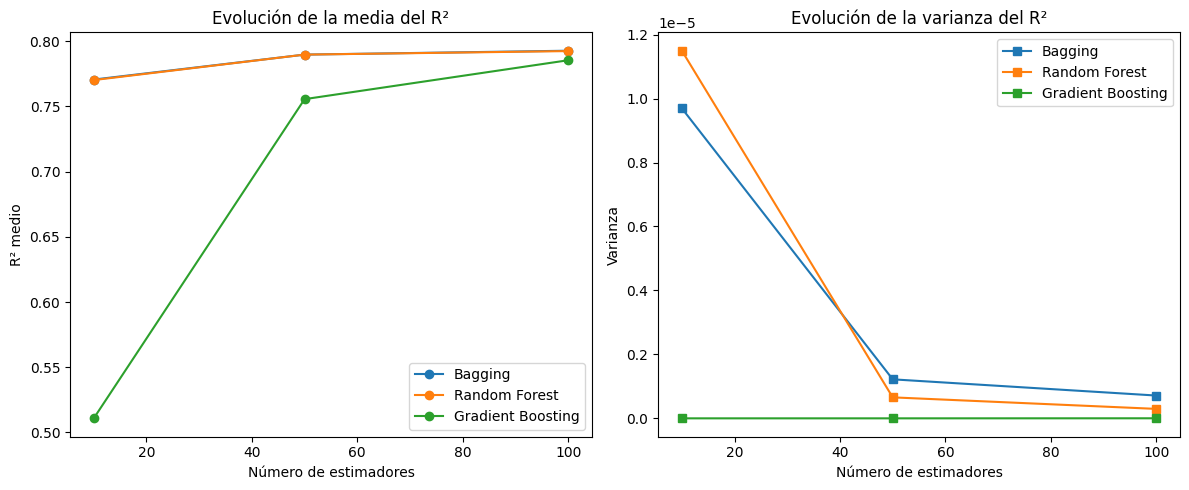

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import r2_score


# 2. Modelos
models = {
    "Bagging": BaggingRegressor(
        estimator=DecisionTreeRegressor(random_state=42),
        random_state=42,
        n_jobs=-1
    ),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# 3. Número de estimadores 
n_estimators_range = [10, 50, 100]

# 4. Guardar resultados
results = {name: [] for name in models.keys()}

# 5. Repetir 5 veces cada modelo para cada número de estimadores
for name, model in models.items():
    print(f"\nEntrenando modelo: {name}")
    for n in n_estimators_range:
        scores = []
        for seed in range(5):  
            model.set_params(n_estimators=n, random_state=seed)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            scores.append(r2_score(y_test, y_pred))
        results[name].append((np.mean(scores), np.var(scores)))

# 6. Representar resultados
plt.figure(figsize=(12,5))

# Media del R²
plt.subplot(1,2,1)
for name in results:
    plt.plot(n_estimators_range, [r[0] for r in results[name]], marker='o', label=name)
plt.title("Evolución de la media del R²")
plt.xlabel("Número de estimadores")
plt.ylabel("R² medio")
plt.legend()

# Varianza del R²
plt.subplot(1,2,2)
for name in results:
    plt.plot(n_estimators_range, [r[1] for r in results[name]], marker='s', label=name)
plt.title("Evolución de la varianza del R²")
plt.xlabel("Número de estimadores")
plt.ylabel("Varianza")
plt.legend()

plt.tight_layout()
plt.show()


En la gráfica de la izquierda se observa que, al aumentar el número de estimadores, la media del R² en test mejora progresivamente hasta estabilizarse. Añadir más árboles hace que los modelos sean más precisos, ya que se reduce la varianza del error y se aprovecha mejor la información del conjunto de entrenamiento. El método **Gradient Boosting** comienza con un rendimiento inferior, puesto que necesita más estimadores para corregir errores de forma secuencial, pero finalmente alcanza valores similares o superiores a los otros métodos. Por su parte, **Bagging** y **Random Forest** logran un rendimiento alto desde pocos estimadores y se estabilizan rápidamente, mostrando una mejora inicial rápida y consistente.

En la gráfica de la derecha se aprecia que la varianza del R² disminuye al aumentar el número de estimadores, lo que indica que los modelos se vuelven más estables y menos sensibles a la aleatoriedad del entrenamiento. **Gradient Boosting** presenta la menor varianza, reflejando una gran consistencia entre ejecuciones, mientras que **Bagging** y **Random Forest** muestran una mayor dispersión inicial que se reduce rápidamente conforme se añaden más árboles. 

En conjunto, los resultados confirman que incrementar el número de estimadores mejora la precisión, la estabilidad y la fiabilidad de los tres métodos. **Gradient Boosting** ofrece el mejor equilibrio entre rendimiento y consistencia, aunque **Bagging** y **Random Forest** también logran mejoras significativas respecto a un único modelo base.



**7. ¿Qué métodos de los anteriores se podrían aplicar si en vez de árboles cada modelo fuera una regresión lineal?**


Si en lugar de utilizar árboles de decisión como modelo base se empleara una regresión lineal, los métodos que seguirían siendo aplicables serían Bagging y Boosting.

* En el caso de Bagging, podrían entrenarse múltiples modelos de regresión lineal sobre diferentes subconjuntos del conjunto de entrenamiento, y posteriormente promediar sus predicciones. Esto reduciría la varianza y aumentaría la estabilidad del modelo.

* En Boosting, cada modelo lineal se entrenaría de forma secuencial para corregir los errores del anterior, combinando varias regresiones simples en un modelo lineal más preciso.

Por el contrario, Random Forest no sería aplicable, ya que este método depende directamente del uso de árboles de decisión y de la selección aleatoria de características en cada nodo.

#### **3.2. Bagging para mejorar otros modelos**

Los *ensembles* no solo son válidos para árboles sino que se pueden utilizar para otros modelos, en la sección actual se le propone que utilice un modelo de *bagging* para resolver el siguiente problema de clasificación de círculos concéntricos:


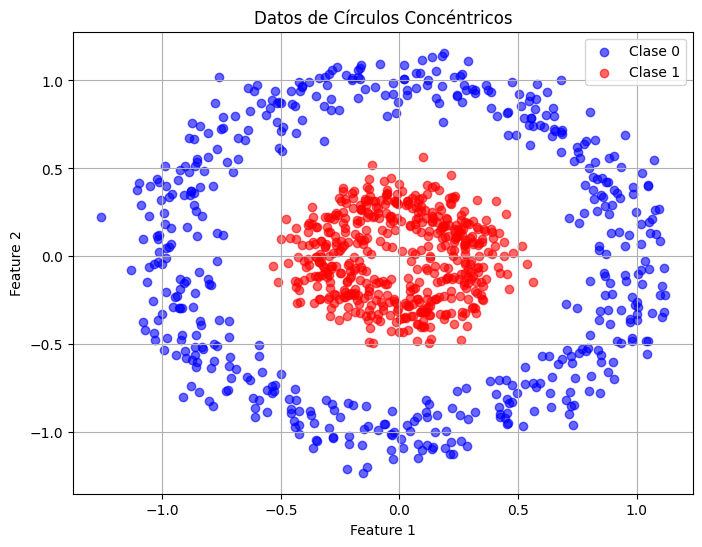

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# Paso 1: Generar datos de c ́ırculos conc ́entricos
X, y = make_circles(n_samples=1000, noise=0.1, factor=0.3, random_state=42)
# Visualizar los datos
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1],
color='blue', label='Clase 0', alpha=0.6)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1],
color='red', label='Clase 1', alpha=0.6)
plt.title('Datos de Círculos Concéntricos')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid()
plt.show()
# Paso 2: Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.5, random_state=42)


Para resolver el problema siga la siguiente guía:

1. Resuelva primero el problema usando un solo estimador del clasificador **LogisticRegression**, que puede encontrar en *Sklearn*. Tras ello dé una métrica de error.


In [20]:
# Definir pipeline con escalado y regresión logística ---
pipe = Pipeline([
    ('scaler', StandardScaler()),          # paso 1: escalado
    ('logreg', LogisticRegression())       # paso 2: modelo
])

# Entrenar pipeline ---
pipe.fit(X_train, y_train)

# Predecir y evaluar ---
y_pred = pipe.predict(X_test)
acc_base = accuracy_score(y_test, y_pred)

print(f"Accuracy del modelo base: {acc_base:.4f}")

Accuracy del modelo base: 0.5100



2. Tras ello realice un *ensemble* de *bagging* con *bootstrapping* y dé una métrica de error. Para resolver este apartado puede utilizar la clase **BaggingClassifier** de *Sklearn*.


In [21]:
from sklearn.ensemble import BaggingClassifier

bagging_model = BaggingClassifier(
    estimator=Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression())
    ]),
    n_estimators=50,       # número de modelos base
    max_samples=0.8,       # cada modelo ve el 80% del train (bootstrapping)
    bootstrap=True,        # activamos bootstrapping
    n_jobs=-1,             # usar todos los núcleos
    random_state=42
)

bagging_model.fit(X_train, y_train)
y_pred_bag = bagging_model.predict(X_test)
acc_bag = accuracy_score(y_test, y_pred_bag)

print(f"Accuracy ensemble: {acc_bag:.4f}")


Accuracy ensemble: 0.5040



3. Compare los errores del modelo de un estimador frente al *ensemble* y justifique qué modelo es mejor y qué es lo que está ocurriendo.


In [22]:
print("\nComparación de resultados:")
print(f"Modelo base:  {acc_base:.4f}")
print(f"Bagging:      {acc_bag:.4f}")

if acc_bag > acc_base:
    print("El ensemble con Bagging mejora el accuracy respecto al modelo base.")
else:
    print("El ensemble no mejora significativamente el modelo base en este caso.")


Comparación de resultados:
Modelo base:  0.5100
Bagging:      0.5040
El ensemble no mejora significativamente el modelo base en este caso.


El modelo base (Regresión Logística) tiene un accuracy de 0.51 y el ensemble con Bagging 0.504, casi igual, así que no hay mejora.

Esto pasa porque la Regresión Logística es un modelo muy estable y robusto. Cuando se entrena varias veces con distintos datos (como hace Bagging), todos los modelos salen casi iguales, porque los datos que cambian entre las muestras bootstrap apenas afectan al resultado.

Como todos los modelos del conjunto son casi iguales, no hay diversidad, y el ensemble no puede mejorar el rendimiento.

Bagging sirve para mejorar modelos que cambian mucho al entrenarse (como los árboles de decisión), pero con modelos lineales no funciona bien por eso.

Si entrenáramos varios modelos lineales con datos realmente distintos (por ejemplo, uno solo con los puntos de la izquierda y otro con los de la derecha), entonces sí podría mejorar.